In [1]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

In [2]:
import os
import random
import shutil
import numpy as np

import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, MultiRNNCell, DropoutWrapper

from helpers import Indexer, batch
from itertools import chain, product
from collections import defaultdict

### Prepare data

In [3]:
SHARED_SIZE = 2 # size of noise (or, common vocab for all types).

TYPES = ['ANIMAL','VEHICLE','NATURE','FURNITURE','FRUIT']
SHARED_VOCAB = ['share'+str(i+1) for i in range(SHARED_SIZE)]
TYPE2VOCAB = {'ANIMAL': ['cat','dog','pig','horse','deer']            + SHARED_VOCAB,
              'VEHICLE': ['car','bike','motorcycle','train','bus']    + SHARED_VOCAB,
              'NATURE': ['hill','mountain','lake','river','valley']   + SHARED_VOCAB,
              'FURNITURE': ['stool','table','closet','cabinet','bed'] + SHARED_VOCAB,
              'FRUIT': ['apple','pear','strawberry','grape','tomato'] + SHARED_VOCAB}
VOCAB = list(chain.from_iterable(TYPE2VOCAB.values()))

indexer = Indexer()
indexer.get_index('PAD')
for word in VOCAB:
    indexer.get_index(word)

In [4]:
DOC_LEN = 5
SENT_FROM_LEN = 5
SENT_TO_LEN = 15

def to_sent(code):
    return [indexer.get_object(idx) for idx in code]

def get_rand_sent_code(sem_type, sent_len):
    return [indexer.get_index(np.random.choice(TYPE2VOCAB[sem_type])) for _ in range(sent_len)]

def get_mixture(type1, type2):
    doc_a = [get_rand_sent_code(type1, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_b = [get_rand_sent_code(type2, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_mix = np.array(doc_a[:] + doc_b[:])
    doc_lbs = np.array([0]*DOC_LEN + [1]*DOC_LEN)
    indices = list(range(DOC_LEN*2))
    random.shuffle(indices)
    doc_mix = doc_mix[indices]
    doc_lbs = doc_lbs[indices]
    return doc_a, doc_b, doc_mix, doc_lbs
    
def batch_mixture(doc_a, doc_b, k):
    batch_x1, batch_x2, batch_y = [], [], []
    ys = [1,0,0,1]
    for _ in range(k):
        for i,(da,db) in enumerate(product([doc_a,doc_b],[doc_a,doc_b])):
            batch_x1.append(random.choice(da))
            batch_x2.append(random.choice(db))
            batch_y.append(ys[i])
    return batch(batch_x1), batch(batch_x2), np.array(batch_y)

def get_batch(n=40):
    if n%4!=0:
        raise ValueError('The current generation scheme only supports multiples of 4 for batch size!')
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
    doc_a, doc_b, _, _ = get_mixture(type1, type2) # document mixtures and labels aren't germane here.
    (batch_x1,batch_x1_len), (batch_x2,batch_x2_len), batch_y = batch_mixture(doc_a,doc_b,n//4)
    return batch_x1,batch_x1_len,batch_x2,batch_x2_len,batch_y

In [5]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

VOCAB_SIZE = len(indexer)
EMB_SIZE = 20
HID_SIZE = 10
NUM_LAYERS = 2
KEEP_PROB = 0.7

input_x1 = tf.placeholder(tf.int32, [None, None], name='input_x1') # <max-time, batch-size>
input_x2 = tf.placeholder(tf.int32, [None, None], name='input_x2')
input_x1_length = tf.placeholder(tf.int32, [None], name='input_x1_length')
input_x2_length = tf.placeholder(tf.int32, [None], name='input_x2_length')
input_y  = tf.placeholder(tf.int32, [None], name='input_y')

keep_prob = tf.placeholder(tf.float32, name="keep_prob")

with tf.variable_scope('Embeddings'):
    embeddings = tf.get_variable('embeddings', [VOCAB_SIZE, EMB_SIZE], 
                                 initializer=tf.contrib.layers.xavier_initializer())
    input_x1_embedded = tf.nn.embedding_lookup(embeddings, input_x1) # <max-time, batch-size, emb-size>
    input_x2_embedded = tf.nn.embedding_lookup(embeddings, input_x2)

cell = MultiRNNCell([DropoutWrapper(LSTMCell(HID_SIZE),output_keep_prob=keep_prob)]*NUM_LAYERS) 

def run_lstm(cell, inputs, inputs_length): # lstm-out size *= 2 by bidirectionality.
    ((fw_outputs,bw_outputs), # <max-time, batch-size, hid-size>, attention later if needed.
     (fw_final_state,bw_final_state)) = ( # <batch-size, hid-size>
        tf.nn.bidirectional_dynamic_rnn(cell_fw=cell,
                                        cell_bw=cell,
                                        inputs=inputs,
                                        sequence_length=inputs_length,
                                        dtype=tf.float32, time_major=True)
    )
    return tf.concat([tf.concat([fw_state_tuple.h,bw_state_tuple.h], 1) # lstm-out size *= NUM_LAYERS by stacking.
                      for fw_state_tuple,bw_state_tuple in zip(fw_final_state,bw_final_state)], 1)
    
with tf.variable_scope('Bi-LSTM') as scope:
    final_state_x1 = run_lstm(cell, input_x1_embedded, input_x1_length)
    scope.reuse_variables() # both sentence inputs share the same weights.
    final_state_x2 = run_lstm(cell, input_x2_embedded, input_x2_length)
    
lstm_out_size = HID_SIZE * 2 * NUM_LAYERS
W_bi = tf.get_variable('W_bi', [lstm_out_size, lstm_out_size], initializer=tf.contrib.layers.xavier_initializer())
scores = tf.nn.sigmoid(tf.diag_part(tf.matmul(tf.matmul(final_state_x1,W_bi),tf.transpose(final_state_x2))),name='scores')
predictions = tf.cast(tf.round(scores), tf.int32, name='predictions') 

with tf.name_scope('Loss'):
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(input_y, tf.float32), logits=scores)
    loss = tf.reduce_mean(losses)

with tf.name_scope('Accuracy'):
    correct_predictions = tf.equal(predictions, input_y)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(1e-5)
grads_and_vars = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step, name='train_op')

sess.run(tf.global_variables_initializer())

In [6]:
NUM_EPOCHS = 50
NUM_BATCHES = 1000
VERBOSE = 100

loss_track, accuracy_track = [], []
for e in range(NUM_EPOCHS):
    print('Epoch ', e+1)
    print('\n')
    curr_loss_track, curr_accuracy_track = [], []
    for _ in range(NUM_BATCHES):
        batch_x1, batch_x1_length, batch_x2, batch_x2_length, batch_y = get_batch()
        fd = {input_x1:batch_x1, input_x1_length:batch_x1_length,
              input_x2:batch_x2, input_x2_length:batch_x2_length,
              input_y:batch_y,
              keep_prob:KEEP_PROB}
        _, step, loss_, accuracy_ = sess.run([train_op, global_step, loss, accuracy], feed_dict=fd)
        curr_loss_track.append(loss_)
        curr_accuracy_track.append(accuracy_)
        if step%VERBOSE==0:
            print('  batch loss & accuracy at step {}: <{}, {}>'.format(step, loss_, accuracy_))
    print('\n')
    print('  epoch mean loss & accuracy: <{}, {}>'.format(np.mean(curr_loss_track),np.mean(curr_accuracy_track)))
    print('\n')    
    loss_track += curr_loss_track
    accuracy_track += curr_accuracy_track

Epoch  1


  batch loss & accuracy at step 100: <0.7246396541595459, 0.4749999940395355>
  batch loss & accuracy at step 200: <0.7232811450958252, 0.675000011920929>
  batch loss & accuracy at step 300: <0.7237483859062195, 0.5000000596046448>
  batch loss & accuracy at step 400: <0.7239110469818115, 0.574999988079071>
  batch loss & accuracy at step 500: <0.7233768105506897, 0.6499999761581421>
  batch loss & accuracy at step 600: <0.7238601446151733, 0.550000011920929>
  batch loss & accuracy at step 700: <0.7232406735420227, 0.6000000238418579>
  batch loss & accuracy at step 800: <0.7238027453422546, 0.550000011920929>
  batch loss & accuracy at step 900: <0.7217633128166199, 0.625>
  batch loss & accuracy at step 1000: <0.7232192158699036, 0.5>


  epoch mean loss & accuracy: <0.7235453128814697, 0.5474749803543091>


Epoch  2


  batch loss & accuracy at step 1100: <0.7230905294418335, 0.625>
  batch loss & accuracy at step 1200: <0.723080039024353, 0.6500000357627869>
  batch lo

  batch loss & accuracy at step 11100: <0.6969945430755615, 0.5>
  batch loss & accuracy at step 11200: <0.6919843554496765, 0.5>
  batch loss & accuracy at step 11300: <0.652456521987915, 0.7000000476837158>
  batch loss & accuracy at step 11400: <0.6914494037628174, 0.5>
  batch loss & accuracy at step 11500: <0.634476363658905, 0.7250000238418579>
  batch loss & accuracy at step 11600: <0.6949870586395264, 0.5>
  batch loss & accuracy at step 11700: <0.6203379034996033, 0.75>
  batch loss & accuracy at step 11800: <0.6508866548538208, 0.675000011920929>
  batch loss & accuracy at step 11900: <0.6812433004379272, 0.5>
  batch loss & accuracy at step 12000: <0.6260727047920227, 0.75>


  epoch mean loss & accuracy: <0.6663870811462402, 0.5870250463485718>


Epoch  13


  batch loss & accuracy at step 12100: <0.605585515499115, 0.75>
  batch loss & accuracy at step 12200: <0.6028497815132141, 0.75>
  batch loss & accuracy at step 12300: <0.6093348860740662, 0.75>
  batch loss & accurac

  batch loss & accuracy at step 21600: <0.5663388967514038, 0.8250000476837158>
  batch loss & accuracy at step 21700: <0.6891533732414246, 0.5>
  batch loss & accuracy at step 21800: <0.5999205708503723, 0.75>
  batch loss & accuracy at step 21900: <0.5925284624099731, 0.75>
  batch loss & accuracy at step 22000: <0.5985943078994751, 0.75>


  epoch mean loss & accuracy: <0.630842387676239, 0.6814749836921692>


Epoch  23


  batch loss & accuracy at step 22100: <0.596637487411499, 0.75>
  batch loss & accuracy at step 22200: <0.6040037274360657, 0.75>
  batch loss & accuracy at step 22300: <0.6878870725631714, 0.5>
  batch loss & accuracy at step 22400: <0.6144274473190308, 0.75>
  batch loss & accuracy at step 22500: <0.5943541526794434, 0.75>
  batch loss & accuracy at step 22600: <0.6042606830596924, 0.75>
  batch loss & accuracy at step 22700: <0.6896741390228271, 0.5>
  batch loss & accuracy at step 22800: <0.6044119596481323, 0.75>
  batch loss & accuracy at step 22900: <0.6054

  batch loss & accuracy at step 32100: <0.5159870386123657, 1.0>
  batch loss & accuracy at step 32200: <0.6049248576164246, 0.75>
  batch loss & accuracy at step 32300: <0.5977310538291931, 0.75>
  batch loss & accuracy at step 32400: <0.6303402185440063, 0.6499999761581421>
  batch loss & accuracy at step 32500: <0.6011765003204346, 0.75>
  batch loss & accuracy at step 32600: <0.6167826652526855, 0.75>
  batch loss & accuracy at step 32700: <0.5047307014465332, 1.0>
  batch loss & accuracy at step 32800: <0.5051450133323669, 1.0>
  batch loss & accuracy at step 32900: <0.6135790348052979, 0.75>
  batch loss & accuracy at step 33000: <0.5308746099472046, 0.9500000476837158>


  epoch mean loss & accuracy: <0.5879615545272827, 0.7956500053405762>


Epoch  34


  batch loss & accuracy at step 33100: <0.6349431276321411, 0.625>
  batch loss & accuracy at step 33200: <0.601086437702179, 0.75>
  batch loss & accuracy at step 33300: <0.5200091004371643, 0.9749999642372131>
  batch loss & a

  batch loss & accuracy at step 43000: <0.5038705468177795, 1.0>


  epoch mean loss & accuracy: <0.5807432532310486, 0.7996500134468079>


Epoch  44


  batch loss & accuracy at step 43100: <0.5032052993774414, 1.0>
  batch loss & accuracy at step 44400: <0.5982208251953125, 0.75>
  batch loss & accuracy at step 44500: <0.5987822413444519, 0.75>
  batch loss & accuracy at step 44600: <0.5032256841659546, 1.0>
  batch loss & accuracy at step 44700: <0.5985952615737915, 0.75>
  batch loss & accuracy at step 44800: <0.5988613963127136, 0.75>
  batch loss & accuracy at step 44900: <0.5032052397727966, 1.0>
  batch loss & accuracy at step 45000: <0.5981733202934265, 0.75>


  epoch mean loss & accuracy: <0.5830615162849426, 0.7926000356674194>


Epoch  46


  batch loss & accuracy at step 45100: <0.595386803150177, 0.75>
  batch loss & accuracy at step 45200: <0.5990353226661682, 0.75>
  batch loss & accuracy at step 45300: <0.5937140583992004, 0.75>
  batch loss & accuracy at step 45400: 

In [7]:
# Save model

saver = tf.train.Saver()
save_dir = "/home/04233/sw33286/AIDA-tests/MODEL-SAVE/Bi-LSTM-HAC-wo-context/"
save_path = save_dir + "stacked-bilstm-doc-mix-mock-00"
saver.save(sess, save_path)

'/home/04233/sw33286/AIDA-tests/MODEL-SAVE/Bi-LSTM-HAC-wo-context/stacked-bilstm-doc-mix-mock-00'

### Restore & Cont'd Training

In [10]:
# import sys
# sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

In [12]:
# # Import utilities

# import random
# import shutil
# import numpy as np

# import tensorflow as tf
# from tensorflow.contrib.rnn import LSTMCell, MultiRNNCell, DropoutWrapper

# from helpers import Indexer, batch
# from itertools import chain, product

# # Data generation block

# SHARED_SIZE = 2 # size of noise (or, common vocab for all types).

# TYPES = ['ANIMAL','VEHICLE','NATURE','FURNITURE','FRUIT']
# SHARED_VOCAB = ['share'+str(i+1) for i in range(SHARED_SIZE)]
# TYPE2VOCAB = {'ANIMAL': ['cat','dog','pig','horse','deer']            + SHARED_VOCAB,
#               'VEHICLE': ['car','bike','motorcycle','train','bus']    + SHARED_VOCAB,
#               'NATURE': ['hill','mountain','lake','river','valley']   + SHARED_VOCAB,
#               'FURNITURE': ['stool','table','closet','cabinet','bed'] + SHARED_VOCAB,
#               'FRUIT': ['apple','pear','strawberry','grape','tomato'] + SHARED_VOCAB}
# VOCAB = list(chain.from_iterable(TYPE2VOCAB.values()))

# indexer = Indexer()
# indexer.get_index('PAD')
# for word in VOCAB:
#     indexer.get_index(word)
    
# DOC_LEN = 5
# SENT_FROM_LEN = 5
# SENT_TO_LEN = 15

# def to_sent(code):
#     return [indexer.get_object(idx) for idx in code]

# def get_rand_sent_code(sem_type, sent_len):
#     return [indexer.get_index(np.random.choice(TYPE2VOCAB[sem_type])) for _ in range(sent_len)]

# def get_mixture(type1, type2):
#     doc_a = [get_rand_sent_code(type1, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
#     doc_b = [get_rand_sent_code(type2, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
#     doc_mix = np.array(doc_a[:] + doc_b[:])
#     doc_lbs = np.array([0]*DOC_LEN + [1]*DOC_LEN)
#     indices = list(range(DOC_LEN*2))
#     random.shuffle(indices)
#     doc_mix = doc_mix[indices]
#     doc_lbs = doc_lbs[indices]
#     return doc_a, doc_b, doc_mix, doc_lbs
    
# def batch_mixture(doc_a, doc_b, k):
#     batch_x1, batch_x2, batch_y = [], [], []
#     ys = [1,0,0,1]
#     for _ in range(k):
#         for i,(da,db) in enumerate(product([doc_a,doc_b],[doc_a,doc_b])):
#             batch_x1.append(random.choice(da))
#             batch_x2.append(random.choice(db))
#             batch_y.append(ys[i])
#     return batch(batch_x1), batch(batch_x2), np.array(batch_y)

# def get_batch(n=40):
#     if n%4!=0:
#         raise ValueError('The current generation scheme only supports multiples of 4 for batch size!')
#     type1, type2 = np.random.choice(TYPES, 2, replace=False)
#     doc_a, doc_b, _, _ = get_mixture(type1, type2) # document mixtures and labels aren't germane here.
#     (batch_x1,batch_x1_len), (batch_x2,batch_x2_len), batch_y = batch_mixture(doc_a,doc_b,n//4)
#     return batch_x1,batch_x1_len,batch_x2,batch_x2_len,batch_y
# # Model restoration block

# restore_dir = "/home/04233/sw33286/AIDA-tests/MODEL-SAVE/Bi-LSTM-HAC-wo-context/"

# sess = tf.Session()

# saver = tf.train.import_meta_graph(restore_dir+'stacked-bilstm-doc-mix-mock-00.meta')
# saver.restore(sess, tf.train.latest_checkpoint(restore_dir))
# graph = tf.get_default_graph()

# VOCAB_SIZE = len(indexer)
# EMB_SIZE = 20
# HID_SIZE = 10
# NUM_LAYERS = 2
# KEEP_PROB = 0.7

# input_x1 = graph.get_tensor_by_name('input_x1:0')
# input_x2 = graph.get_tensor_by_name('input_x2:0')
# input_x1_length = graph.get_tensor_by_name('input_x1_length:0')
# input_x2_length = graph.get_tensor_by_name('input_x2_length:0')
# input_y = graph.get_tensor_by_name('input_y:0')
# keep_prob = graph.get_tensor_by_name('keep_prob:0')

# scores = graph.get_tensor_by_name('scores:0')
# predictions = graph.get_tensor_by_name('predictions:0')
# loss = graph.get_tensor_by_name('Loss/Mean:0')
# accuracy = graph.get_tensor_by_name('Accuracy/accuracy:0')
# global_step = graph.get_tensor_by_name('global_step:0')
# train_op = graph.get_tensor_by_name('train_op:0')

In [13]:
# NUM_EPOCHS = 50
# NUM_BATCHES = 1000
# VERBOSE = 100

# loss_track, accuracy_track = [], []
# for e in range(NUM_EPOCHS):
#     print('Epoch ', e+1)
#     print('\n')
#     curr_loss_track, curr_accuracy_track = [], []
#     for _ in range(NUM_BATCHES):
#         batch_x1, batch_x1_length, batch_x2, batch_x2_length, batch_y = get_batch()
#         fd = {input_x1:batch_x1, input_x1_length:batch_x1_length,
#               input_x2:batch_x2, input_x2_length:batch_x2_length,
#               input_y:batch_y}
#         _, step, loss_, accuracy_ = sess.run([train_op, global_step, loss, accuracy], feed_dict=fd)
#         curr_loss_track.append(loss_)
#         curr_accuracy_track.append(accuracy_)
#         if step%VERBOSE==0:
#             print('  batch loss & accuracy at step {}: <{}, {}>'.format(step, loss_, accuracy_))
#     print('\n')
#     print('  epoch mean loss & accuracy: <{}, {}>'.format(np.mean(curr_loss_track),np.mean(curr_accuracy_track)))
#     print('\n')    
#     loss_track += curr_loss_track
#     accuracy_track += curr_accuracy_track

In [ ]:
# saver = tf.train.Saver()
# save_dir = "/home/04233/sw33286/AIDA-tests/MODEL-SAVE/GROUPER-MOCK/"
# save_path = save_dir + "stacked-bilstm-doc-mix-mock-00"
# shutil.rmtree(save_dir)
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
# saver.save(sess, save_path)

### Bi-LSTM + HAC

In [121]:
import numpy as np
import tensorflow as tf
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

class ClfHAC:
    
    def __init__(self, clf_dir, clf_filename):
        self.sess = tf.Session()
        saver = tf.train.import_meta_graph(clf_dir + clf_filename)
        saver.restore(self.sess, tf.train.latest_checkpoint(clf_dir))
        self.graph = tf.get_default_graph()
        self.input_x1 = self.graph.get_tensor_by_name('input_x1:0')
        self.input_x2 = self.graph.get_tensor_by_name('input_x2:0')
        self.input_x1_length = self.graph.get_tensor_by_name('input_x1_length:0')
        self.input_x2_length = self.graph.get_tensor_by_name('input_x2_length:0')
        self.input_y = self.graph.get_tensor_by_name('input_y:0')
        self.keep_prob = self.graph.get_tensor_by_name('keep_prob:0')

        self.scores = self.graph.get_tensor_by_name('scores:0')
        self.predictions = self.graph.get_tensor_by_name('predictions:0')
        self.loss = self.graph.get_tensor_by_name('Loss/Mean:0')
        self.accuracy = self.graph.get_tensor_by_name('Accuracy/accuracy:0')
        self.global_step = self.graph.get_tensor_by_name('global_step:0')
        self.train_op = self.graph.get_tensor_by_name('train_op:0')
        
        
    def dist(self, x1, x2):
        x1, x1_len = batch([x1])
        x2, x2_len = batch([x2])
        fd = {self.input_x1:x1, self.input_x1_length:x1_len,
              self.input_x2:x2, self.input_x2_length:x2_len,
              self.keep_prob:1.0}
        conf = self.sess.run(self.scores, feed_dict=fd)
        return 1-conf[0]
    
    def evaluate(self, doc_mix, doc_lbs, method='average', plot=True):
        doc_mix_sq, _ = batch(doc_mix)
        doc_mix_sq = doc_mix_sq.T
        doc_mix_clust = linkage(doc_mix_sq, method=method, metric=self.dist)
        # evaluate by class-based prec/rec/f1
        doc_prd = fcluster(clust, 2, criterion='maxclust') # predicted assignments
        eval_input = clust_to_eval_input(doc_prd, doc_lbs)
        prec, rec = cb_prec(*eval_input), cb_rec(*eval_input)
        f1 = cb_f1(prec, rec)
        if plot:
            print('Class-based clustering evaluation:')
            print('Precision = {} | Recall = {} | F1 = {}'.format(prec,rec,f1))
            print('\n')
            plt.figure(figsize=(25, 10))
            plt.title('Hierarchical Clustering Dendrogram')
            plt.xlabel('sample index')
            plt.ylabel('distance')
            dendrogram(
                doc_mix_clust,
                leaf_rotation=90.,  # rotates the x axis labels
                leaf_font_size=15.,  # font size for the x axis labels
            )
            plt.show() 
            print('True | Pred | Sentence')
            for label,pred_label,code in zip(doc_lbs,doc_prd,doc_mix):
                print('{}    | {}    | {}'.format(label,pred_label,to_sent(code)))
            print('\n')
        else:
            return doc_mix_clust, prec, rec, f1
        
        
def clust_to_eval_input(pred_clust, true_clust):
    pred_ass2cls, pred_cls2ass = [], defaultdict(list)
    true_ass2cls, true_cls2ass = [], defaultdict(list)
    for item_id,(pred_ass,true_ass) in enumerate(zip(pred_clust,true_clust)):
        pred_ass2cls.append((item_id,pred_ass))
        true_ass2cls.append((item_id,true_ass))
        pred_cls2ass[pred_ass].append(item_id)
        true_cls2ass[true_ass].append(item_id)
    pred_ass2cls = dict(pred_ass2cls)
    true_ass2cls = dict(true_ass2cls)
    return pred_ass2cls, pred_cls2ass, true_ass2cls, true_cls2ass

def cb(source_a2c, source_c2a, target_a2c, target_c2a):
    prec_num = prec_denom = 0
    for _,ass in source_c2a.items():
        card_ass = len(ass)
        mem_cls = set()
        for elem in ass:
            for t_elem,cls in target_a2c.items():
                if elem==t_elem:
                    mem_cls.add(cls)
        prec_num += card_ass - len(mem_cls)
        prec_denom += card_ass - 1
    return prec_num / prec_denom   

def cb_prec(p_a2c, p_c2a, t_a2c, t_c2a):
    return cb(p_a2c, p_c2a, t_a2c, t_c2a)

def cb_rec(p_a2c, p_c2a, t_a2c, t_c2a):
    return cb(t_a2c, t_c2a, p_a2c, p_c2a)
    
def cb_f1(prec, rec):
    return (2*rec*prec) / (rec+prec)
    

In [122]:
restore_dir = "/home/04233/sw33286/AIDA-tests/MODEL-SAVE/Bi-LSTM-HAC-wo-context/"
restore_filename = 'stacked-bilstm-doc-mix-mock-00.meta'

In [123]:
clf_hac = ClfHAC(restore_dir, restore_filename)

Class-based clustering evaluation:
Precision = 1.0 | Recall = 1.0 | F1 = 1.0




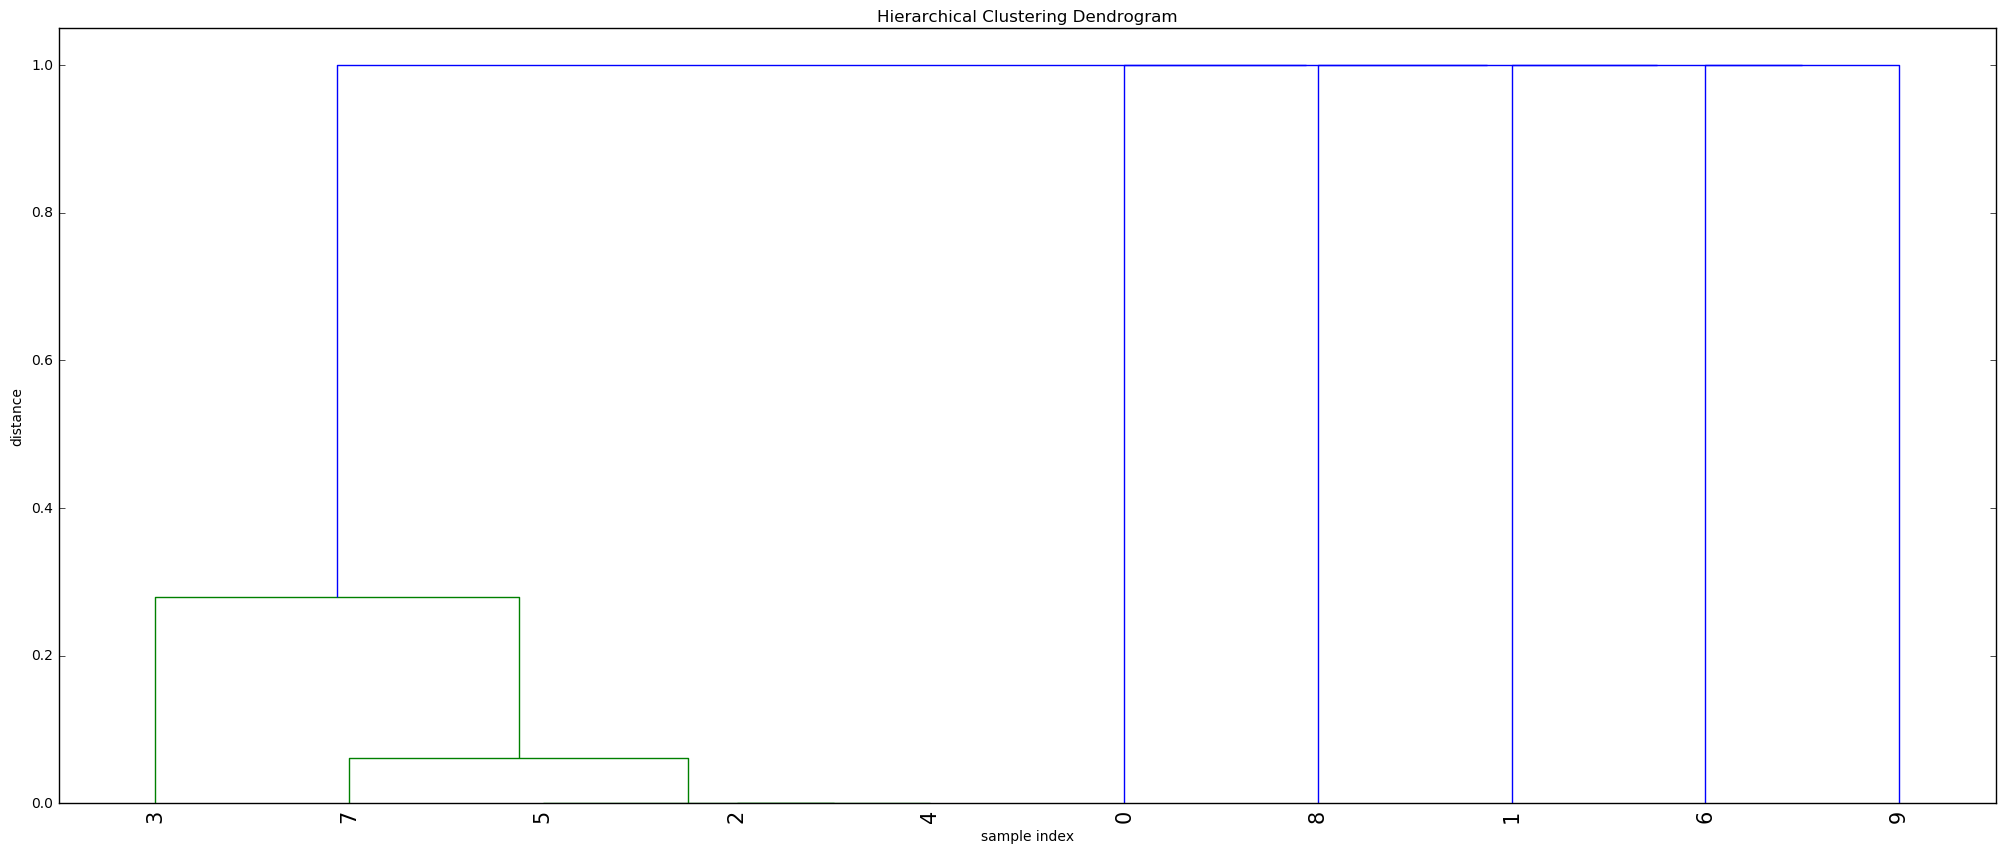

True | Pred | Sentence
1    | 2    | ['motorcycle', 'bus', 'motorcycle', 'share1', 'car', 'bus', 'motorcycle', 'share2']
1    | 2    | ['bike', 'bus', 'car', 'train', 'bus', 'car', 'share1', 'share1']
0    | 1    | ['deer', 'pig', 'share1', 'pig', 'cat', 'pig', 'share2', 'share2', 'cat', 'dog', 'horse', 'share2']
0    | 1    | ['share1', 'deer', 'share1', 'dog', 'horse', 'dog']
0    | 1    | ['horse', 'share1', 'pig', 'share2', 'deer', 'share1', 'dog', 'share2', 'horse', 'pig', 'cat', 'cat']
0    | 1    | ['share2', 'horse', 'pig', 'share1', 'deer', 'share2', 'share1', 'deer']
1    | 2    | ['car', 'motorcycle', 'train', 'bus', 'car', 'train', 'share1']
0    | 1    | ['share2', 'deer', 'pig', 'pig', 'horse']
1    | 2    | ['car', 'motorcycle', 'motorcycle', 'bike', 'share1', 'motorcycle', 'share2', 'car', 'bus', 'bike', 'train', 'share2', 'train', 'bike']
1    | 2    | ['car', 'train', 'car', 'train', 'motorcycle', 'motorcycle']




In [124]:
# da,db,dm,dl = get_mixture('ANIMAL', 'VEHICLE')
clf_hac.evaluate(dm, dl)

In [136]:
# # Evaluating with randomly generated documents

# NUM_DOCS = 1000

# def get_scores_for_rand_doc_mix(clf): # clf: a ClfHAC object.
#     type1, type2 = np.random.choice(TYPES, 2, replace=False)
#     print(type1, type2)
#     _,_,dm,dl = get_mixture(type1, type2) # document a,b don't play into evaluation here.
#     _, prec, rec, f1 = clf.evaluate(dm, dl, plot=False)
#     return prec, rec, f1

# precs,recs,f1s = [],[],[]
# for i in range(NUM_DOCS):
#     prec,rec,f1 = get_scores_for_rand_doc_mix(clf_hac)
#     precs.append(prec)
#     recs.append(rec)
#     f1s.append(f1)
#     if i%10==0:
#         print('Average Prec/Rec/F1 at {} = {}/{}/{}'.format(i+1,np.mean(precs),np.mean(recs),np.mean(f1s)))

In [137]:
# # da,db,dm,dl = get_mixture('ANIMAL', 'VEHICLE')
# clf_hac.evaluate(dm, dl)

In [138]:
# _,_,dm2,dl2 = get_mixture('ANIMAL', 'VEHICLE')
# clf_hac.evaluate(dm2, dl2)